# Model Monitoring using Prometheus and Grafana
**A Workshop by MLReply MLOps Internal CoP (27.07.2022)** 

In this workshop, we will learn how to set up Prometheus and Grafana for real-time monitoring of ML models in production, particularly observing the trends and creating alerts.

Prerequisites:
- Docker and Python installed on your machine
- Internet connection

## Agenda
* Prometheus Intro
* Grafana Intro
* Model Monitoring Intro
* Familiarizing with the dataset and the model
* Setting up an app to serve the model
* Setting up Prometheus and Grafana
* Running simulated requests
* Monitoring using existing dashboards
* Creating several dashboards and alerts

## Prometheus
In a very short version, Prometheus is an open-source monitoring system with a time-series database. Prometheus is built to tackle monitoring with complex **multi-dimentional metrics** at the same time keeping it **operationaly simple**, **scalabe**, and **easy to query**. Prometheus comes with its own query language called PromQL. More info on: https://prometheus.io/

Keep in mind that Prometheus is designed for general system monitoring purposes and it has no ML-specific feature. However, its simplicity and scablability supports designing complex monitoring use cases for model monitoring too.

### Prometheus Architecture

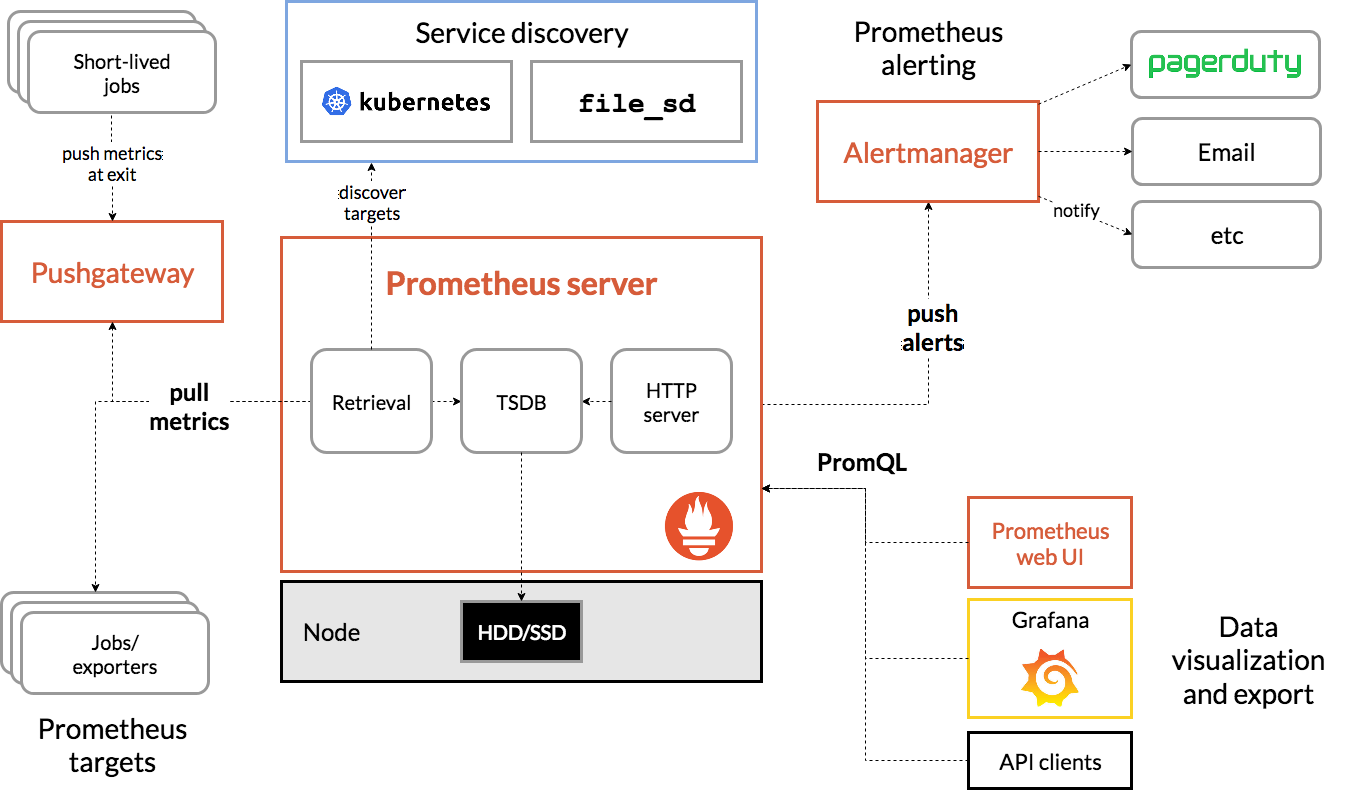

### Prometheus does not give 100% accuracy!!!

Prometheus' main focus is reliability, not accuracy. "Prometheus is **designed for reliability**, to be the system you go to during an outage to allow you to quickly diagnose problems" (from official website).

RELIABILITY <--> ACCURACY

Most of Prometheus functions perform **interpolations and extrapolations**.

Prometheus collects metrics at certain intervals --> missing data

### Prometheus Metric Types

#### Counter (Basic Type)
A counter is a cumulative metric that represents a single monotonically increasing counter whose value can only increase or be reset to zero on restart. **Example: number of requests, number of a predicted class**

#### Gauge (Basic Type)
A gauge is a metric that represents a single numerical value that can arbitrarily go up and down. **Example: memory usage, probability of a predicted class**

#### Histogram (Complex Type based on Counter)
A histogram counts samples cumulatively in configurable buckets. It also provides a sum of all observed values. **Example: any numerical value such as number of requests or probablity**

It will create:

**5 time series of (le 0), (le 0.25), (le 0.50), (le 0.75), (le 1), (le inf)** (le = less than or equal, inf = infinity)

**1 time serie of total_sum**

**1 time serie of total_count**

<center>collected data = {0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9}</center>

| le 0 | le 0.25 | le 0.5 | le 0.75 | le 1 | le inf |
| --- | --- | --- | --- | --- | --- |
| 1 | 3 | 6 | 8 | 10 | 10 |

<center>total_sum = 4.5</center>
<center>total_count = 10</center>

#### Summary (Complex Type based on Gauge)
Almost similar to a histogram, calculates configurable quantiles over a sliding time window on the client side: φ-quantiles (0 ≤ φ ≤ 1) of observed events. **Example: any numerical value such as number of requests or probablity**

**Complete Comparison of Histogram vs. Summary**: https://prometheus.io/docs/practices/histograms/

## Grafana
Grafana is the most common visualization tool (also open-source), particularly for time series. It provides a wide range of graph types and chart types for visualizing time series. More infor on: https://grafana.com/

## Model Monitoring
Here is the link to a presentation with some basic concepts: https://reply.sharepoint.com/:p:/s/MLReply/EQqpbTaDmLRPnDInE2Pd0f8BZqs7ms7eFwmkJmD0LSjaPw?e=oTSN1N
You can learn more about it by reading this article: https://medium.com/p/1f6ee47be653

### Basic Architecture of a Monitoring System

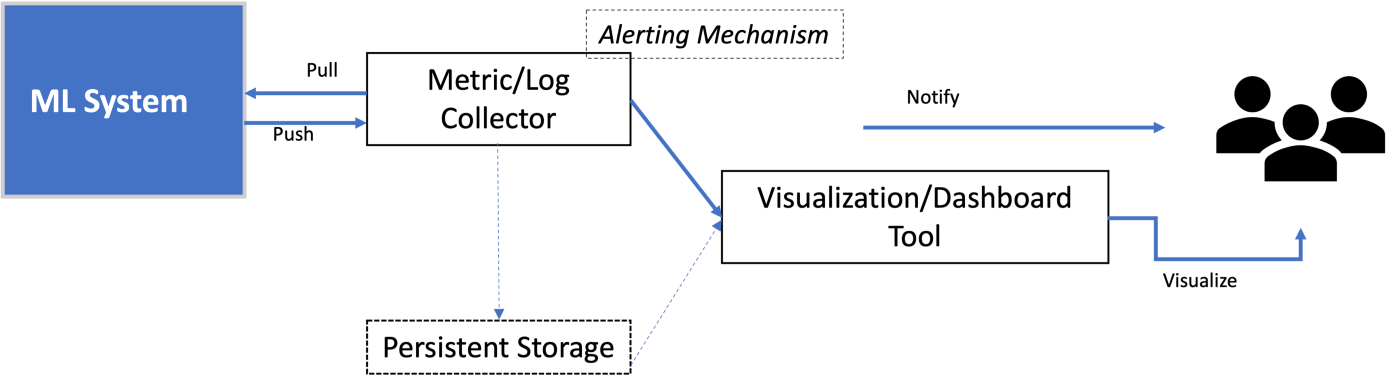

As you can see in the basic architecture, we need a metric collector, which we use Prometheus, and a visualization tool, here Grafana.

Please remember that a complete monitoring system has two mechanisms: monitoring by metrics and monitoring by logs. **In this workshop, using Prometheus and Grafana stack, we set up the monitoring by metrics part. Monitoring by logs is another component that must be added to the system using a different tech stack.** gibr elk stack example

## Dataset and Model

Let's get familirized briefly with the data and model that we want to monitor!

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Loading data from file and taking a look into it

In [ ]:
df = pd.read_csv("stores_dataset.csv")

In [ ]:
df.describe()

In [ ]:
df[:10]

Plotting the data to get more insight about the distributions

In [ ]:
for column_name in df.columns:
  plt.figure(figsize=(7, 7))
  plt.title("{column_name} Distribution".format(column_name = column_name))
  sns.histplot(df[column_name], stat='count',color='green')
  plt.axvline(df[column_name].mean(), color='red', linestyle='--', linewidth=0.8)
  min_ylim, max_ylim = plt.ylim()
  plt.text(df[column_name].mean()*1.05, max_ylim*0.96, 'Mean (μ): {:.2f}'.format(df[column_name].mean()))
  plt.xlabel("Value")
  plt.ylabel("Count")
  plt.show()

#### The Model
- Binary Classification
- Inputs:
    - items_count
    - customers_count
- Output:
    - 0 -> Normal Class
    - 1 -> Successful Class

#### Loading the Model

Import relevant packages for loading the model.

In [ ]:
import mlflow

Loading the model from file using mlflow (the model is packaged using mlflow that's why we need it).

In [ ]:
model_path = "./setup/app/src/model"
model = mlflow.pyfunc.load_model(model_path)

In [ ]:
model.predict([[1000, 1000]])

In [ ]:
model.predict([[2000, 5000]])

## Setting Up Serving Model, Prometheus, and Grafana

We set up everything using containers for sake of simplicity. Hence, the model, Prometheus, and Grafana will be running each inside a seperate container. They will communicate over a network created by docker-compose tool.

**The related files exist under the setup folder. You should find three folders: app, grafana, prometheus and one file: docker-compose.yaml**

docker-compose.yaml file specifies which containers must be run, how (building the image or pulling it from docker hub), port mapping from docker-compose network to our loacl machine, and which files must be mounted to the container.

### app

Let's navigate to the app folder:

- src folder --> where the source code for the microservice which serves the model exist
    - model folder --> the exact model that you already loaded above
    - app.py --> specifications for your microservice using FastAPI framework (for more info about FastAPI: https://fastapi.tiangolo.com/)
- Dockerfile --> the specifications for our docker image
- requirements.txt --> python dependencies/packages that must be installed to run the microservice

#### Let's Check Instrumentation of Metrics

- Open the app.py (setup/src/app.py) and check the metrics together
- We already have the metrics for monitoring model output (predictions) and metrics for monitoring data
- Let's expose more metrics: 
    - **TODO:** Create a gauge for customers count
    - **TODO:** Create a two histogram metrics for the input data: items count and customers count**
        - Hint: here are the quantiles for available items count (according to the training data): [1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750]
        - Hint: here are the quantiles for daily customers count (according to the training data): [200, 400, 600, 800, 1000, 1200, 1400, 1600]


### Prometheus

- prometheus.yaml --> specifications for Prometheus scraping (metric collecting) jobs: which endpoints, ports, how often, etc.

### Grafana

- grafana.ini --> all configurations for the grafana
- provisioning folder --> folder that contains provisioning config files that grafana will apply on startup and while running
    - dashboards folder --> folder that contains config and specifications for grafana dashboards e.g. existing dashboards
    - datasources folder --> folder that contains config of data sources, e.g. Prometheus connection

### Running Containers

- open a terminal/bash/cmd/powershell
- navigate to setup folder
- run the following commands:
    - **docker compose build**
    - **docker compose up**
- checkout the following endpoints on your local machine are up and running:
    - app: **http://localhost:8000/docs**
    - Prometheus: **http://localhost:9090**
    - Grafana: **http://localhost:3000**
        - please log into Grafana using username and password both as: mlreply

## Creating Simulated Requests/Predictions

At this point we have our main components up and running. We are missing some trrafic and inferences by our model. We create such trrafic using a Python script.
- Python Script: scenario_generator.py

We have a scenario generator with different distributions of input varialbes to simulate situations that might happen in real world:
- Normal Scenario: the data at inference will be similar to the data with which we trained the model with
- Faluty Secnario: we will figure it out why it's faulty

### Generating the Scenarios

In [ ]:
! python3 scenario_generator.py

Now let's check our dashboards in Grafana @ http://localhost:3000

#### Let's create some dashboard panels!

To create dashboard panels, you need to write some PromQL queries. Here you can find the manual: https://prometheus.io/docs/prometheus/latest/querying/functions/#rate

- **TODO:** Create a panel for monitoring customers count
- **TODO:** Create a panel for monitoring percentage of successful stores

#### Alerting!

- **TODO:** Create an **alert** to fire when success rate of our stores is under 20%

You can check notification of fired alerts by joining this slack workspace, in general channel: https://join.slack.com/t/mlops-at-mlreply/shared_invite/zt-1czxi7yza-AY1OCoENDhTWWlgLNHq9ww